import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk

In [3]:
#your work should only start with the following code
df=pd.read_csv("A2_Data.csv")

In [2]:
#You need to import all the required libraries in thi cell
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import nltk
import re
import textstat


### Text preparation

In [4]:
df1 = df[['user_followers', 'user_verified', 'text', 'RiseFall']]
#data exploring showed multiple tweets being repeated, they were deleted 
df2 = df1.drop_duplicates()
#converting "Risefall" from boolen to string 
df2["user_verified"] = df2["user_verified"].map({True: 'True', False: 'False'}) 
#dropping unverified users 
df3 = df2[df2['user_verified']=='True']
#resetting index after values dropped 
df4 = df3.reset_index(drop = True)

C:\Users\s4543833\AppData\Local\Temp/ipykernel_20256/1714492451.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["user_verified"] = df2["user_verified"].map({True: 'True', False: 'False'})


### Feature generation 1: Readability

In [5]:
#Readability_list_gunning_fog
Readability_list_gunning_fog = []
for row in df4.iterrows():
        sentence = row[1]['text']
        readability_score = textstat.gunning_fog(sentence)
        Readability_list_gunning_fog.append(readability_score)
df4["Readability_Score"] = Readability_list_gunning_fog

readability of the text is measured before the further processing such that the most accurate readability of the text values are measured. I expect the readability and the ease of the message to affect the "RiseFall" varaible after the tweet is published. A tweet with a lower readability score will be easier to comprehend in the first reading and therefore affect the intention of the readers which will alter the rise and fall values  

### Text preparation continued 

In [14]:
#added punctuations deleted
df4['text'].replace({r'[^\w\s]\S+':''}, regex=True, inplace =True)
#Tokenising
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
df5= df4['text'].apply(word_tokenize)
#Case Folding
df6= df5.apply(lambda x: [word.lower() for word in x])
#Stopwords Removal
from nltk.corpus import stopwords
My_stop_words = stopwords.words("English")
new_stopwords = ["http", "lol", "LOL", "Lol", "HTTP","https"]
My_stop_words.extend(new_stopwords)
df7 = df6.apply(lambda x: [word for word in x if word not in My_stop_words])  
#Stemming
from nltk.stem import SnowballStemmer
My_stemmer = SnowballStemmer("english")
df8 = df7.apply(lambda x:[My_stemmer.stem(word) for word in x])
df9 = df8.apply(lambda x:" ".join(x))
df4['enriched_text'] = df9

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\s4543833\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Feature generation 2: Sentiment

In [7]:
#Sentiment 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
My_sentiment_analyser = SentimentIntensityAnalyzer()
sentimental_text_list = []
for sentence in df4["enriched_text"]:

    text_score = My_sentiment_analyser.polarity_scores(sentence)['compound']
    sentimental_text_list.append(text_score)
df4["Sentiment"] =  sentimental_text_list

Sentiment score from the VaderSentiment package will help us understand the extremity of the opinions expressed by the tweet authors in the tweet. This will help to understand if the extreme views presented during the tweet being published will affect its risefall rating

### Feature generation 3: Length 

In [8]:
df4["Length"] = df4["enriched_text"].str.split().str.len()

Understanding the length of the length of the tweets will indicate the depth of the reviews, given a tweet is longer in length it shows greater effort taken by the tweet author to talk about Bitcoin. I predict that this will directly affect the "RiseFall" rating of the tweet. 

### Feature generation 4: SVD dimension reduction 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
My_vectorizer = TfidfVectorizer ()
TFIDF=My_vectorizer.fit_transform(df4["enriched_text"])
from sklearn.decomposition import TruncatedSVD
My_SVD = TruncatedSVD(n_components=3, n_iter=100)
SVD_Note= My_SVD.fit_transform(TFIDF)
SVD_Note
df4[['SVD1','SVD2', 'SVD3']]=SVD_Note


once the tweets are processed they had more than a few millions of dimenions created, SVD was used to reduce these dimensions from the 

### Visualization wordcloud

In [15]:
from wordcloud import WordCloud
from PIL import Image
unique_string_v2=(" ").join(list(df9.values))
cloud_mask = np.array(Image.open("opengraph.png"))
wordcloud = WordCloud(width = 1000, height = 500, background_color="white",
               mask=cloud_mask, max_words=5000, contour_width=2, contour_color='black')
wordcloud.generate(unique_string_v2)
wordcloud.to_file("word_cloud.png")

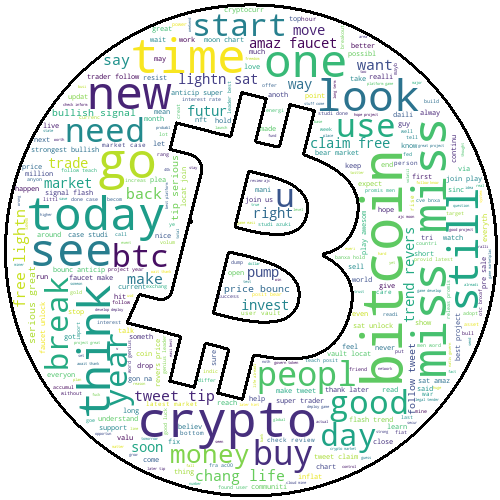

In [17]:
from IPython import display
display.Image("word_cloud.png")

Wordcloud generated as a bitcoin image

In [16]:
#Topic_modelling
from sklearn.feature_extraction.text import TfidfVectorizer
My_vectorizer = TfidfVectorizer ()
import gensim.corpora as corpora

# This code implements the concept of a Dictionary – a mapping between words and their integer ids. 
My_id2word = corpora.Dictionary(df8)

# Convert document (a list of words) into the bag-of-words format
My_Corpus = [My_id2word.doc2bow(text) for text in df8]

# Build LDA model
from gensim import models
My_LDA = models.LdaMulticore(corpus=My_Corpus, id2word=My_id2word, num_topics=3)
import gensim.corpora as corpora

# This code implements the concept of a Dictionary – a mapping between words and their integer ids. 
My_id2word = corpora.Dictionary(df8)

# Convert document (a list of words) into the bag-of-words format
My_Corpus = [My_id2word.doc2bow(text) for text in df8]

# Build LDA model
from gensim import models
My_LDA = models.LdaMulticore(corpus=My_Corpus, id2word=My_id2word, num_topics=3)
#Print topics and keywords
My_LDA.print_topics()
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import os
number_of_topics = 3
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(number_of_topics))

gensimvis.prepare(My_LDA, My_Corpus, My_id2word)

C:\Users\s4543833\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.033532  0.047195       1        1  40.340937
2     -0.037857 -0.045327       2        1  35.742324
1      0.071390 -0.001868       3        1  23.916738, topic_info=         Term          Freq         Total Category  logprob  loglift
34          !   9038.000000   9038.000000  Default  30.0000  30.0000
57       miss   2005.000000   2005.000000  Default  29.0000  29.0000
0           .  30435.000000  30435.000000  Default  28.0000  28.0000
862   project   4426.000000   4426.000000  Default  27.0000  27.0000
22        buy   3045.000000   3045.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
108      time    541.457312   1968.885887   Topic3  -5.4299   0.1396
99      world    416.299417   1134.656884   Topic3  -5.6928   0.4279
1748    token    439.313518   1350.177010   Topic3  -5.6390   0.3078
501     check    430.072151   1753.680604   Topic3  -5.6603   0.0251
2          go    433.483144   2295.281525   Topic3  -5.6524  -0.2362

[264 rows x 6 columns], token_table=      Topic      Freq Term
term                      
34        1  0.424851    !
34        2  0.175251    !
34        3  0.399958    !
44        1  0.201883    %
44        2  0.366802    %
...     ...       ...  ...
733       1  0.965902    🥷
733       2  0.017027    🥷
733       3  0.018575    🥷
3858      2  0.938041    🪱
3858      3  0.078170    🪱

[548 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

Topic modelling used to split text into 3 different topics then displayed 

### Evaluation

In [11]:
df4a = df4[df4["RiseFall"] != "Equal" ]
df4b = df4a[df4a["Length"]>=3]

#You can use only this cell for model evaluation.
nominal_columns=df4b.select_dtypes(include= ['object']) 
numerical_columns=df4b.select_dtypes(exclude= ['object']) 

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

nominal_converted = nominal_columns.apply(le.fit_transform)

df6 = pd.concat([numerical_columns, nominal_converted], axis=1)

from sklearn.neural_network import MLPClassifier
My_ANNclf = MLPClassifier(hidden_layer_sizes=(25,), max_iter=500)
X=df6[["user_followers", "Readability_Score", "Sentiment", "Length", "SVD1", "SVD2", "SVD3"]]
y=df6["RiseFall"]
from sklearn.model_selection import cross_val_score
scores = cross_val_score(My_ANNclf, X, y, cv=6)
scores.mean()

0.5904103433230843

variables generates and compiled were used to run the 6 fold ANN model, the text was ignored. Tweets with  words less than 3 words were also ignored as I predict lenght less than 3 words will not have much effect of the risefall varaible. To predict Risefall accurately I further removed the tweets that had equal rating and did were not affect the risefall variable at all. 

Highlight why either 2 variables or one variables was used